In [1]:
import stream_time_reversability as STR
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tstrippy
import datetime
import multiprocessing as mp
from astropy import units as u
from astropy.coordinates import SkyCoord
import h5py
plt.rcParams.update({'text.usetex': True})

# remake the figures based on Paola and Marco's comments

In [2]:
def print_integration_summary(integrationparameters, hostparams, comptimeretrace, GCname):
    """
    Prints and returns summary statistics for a stream retrace integration.

    Parameters:
        integrationparameters (array-like): Integration parameters, e.g. [start, dt, ..., NSTEPS]
        hostparams (array-like): Host parameters, e.g. [M, q, a]
        comptimeretrace (float): Computation time in seconds
        GCname (str): Name of the globular cluster
        u (astropy.units): Astropy units module

    Returns:
        dict: Dictionary with formatted summary strings and image name
    """

    dt = integrationparameters[1]
    tau = np.sqrt(hostparams[2]**3 / (hostparams[0] * hostparams[1]))
    alpha = dt / tau
    n_steps_per_tau = tau / dt

    # Format alpha (dt/tau) in scientific notation
    mantissa = 10**(int(np.floor(np.log10(abs(alpha)))))
    exponent = int(np.floor(np.log10(abs(alpha))))
    alpha_formatted = r"${:.1f} \times 10^{{{}}}$".format(mantissa*10, exponent-1)

    print(f"Timestep: dt = {dt}")
    print(f"Dynamical time: τ = {tau:.5f}")
    print(f"Number of steps per dynamical time: {n_steps_per_tau:.1f}")
    print(f"Ratio dt/τ = {alpha_formatted}")

    boost = 1
    matissa = 10**(np.log10(alpha) - int(np.log10(alpha)) + boost)
    exponent_boost = int(np.log10(alpha)) - boost
    alpha_formatted_boost = r"$\Delta t = {:.1f} \times 10^{{{}}} \tau$".format(matissa, exponent_boost)
    print(f"Boosted ratio dt/τ = {alpha_formatted_boost}")

    text_comp_time = r"$\mathrm{{Comp~time}} = {:.2f}~\mathrm{{s}}$".format(comptimeretrace)
    integrationtime = integrationparameters[-1] * integrationparameters[1]
    NSTEPS = int(integrationparameters[-1])
    integrationtime = integrationtime * (u.s * (u.kpc / u.km))
    integrationtime = integrationtime.to(u.Myr)
    text_integration_time = r"$\mathrm{{T}} = {:.0f}~\mathrm{{Myr}}$".format(integrationtime.value)
    print(text_comp_time)
    print(text_integration_time)

    image_name = "NumericalErrorStreamRetrace_{:s}_Nsteps_{:d}_stepsPerTau_{:d}.png".format(
        GCname, NSTEPS, int(n_steps_per_tau)
    )

    return {
        "alpha_formatted": alpha_formatted,
        "alpha_formatted_boost": alpha_formatted_boost,
        "text_comp_time": text_comp_time,
        "text_integration_time": text_integration_time,
        "image_name": image_name
    }

In [3]:
def compute_and_report_energy_errors(staticgalaxy, hostparams, hostorbit, streaminitial, streamfinal, stream_retrace):
    """
    Computes and prints the energy errors for stream retrace analysis.

    Parameters:
        staticgalaxy: list or array, static galaxy parameters (use staticgalaxy[1])
        hostparams: array-like, host parameters
        hostorbit: array-like, host orbit data
        streaminitial: array-like, initial stream data
        streamfinal: array-like, final stream data
        stream_retrace: array-like, retraced stream data
        STR: module or object with compute_stream_energy method

    Returns:
        dict: Dictionary with computed energies and errors
    """

    phiMW0, phiHost0, T0 = STR.compute_stream_energy(staticgalaxy[1], hostparams, hostorbit[:, 0], streaminitial)
    phiMWstream, phiHoststream, Tstream = STR.compute_stream_energy(staticgalaxy[1], hostparams, hostorbit[:, -1], streamfinal)
    phiMWR, phiHostR, TR = STR.compute_stream_energy(staticgalaxy[1], hostparams, hostorbit[:, 0], stream_retrace)

    E0 = phiMW0 + phiHost0 + T0
    Estream = phiMWstream + phiHoststream + Tstream
    ER = phiMWR + phiHostR + TR

    errEFinal = np.abs((Estream - E0) / E0)
    errERetrace = np.abs((ER - E0) / E0)

    print(f"Energy error in stream retrace: {np.mean(errERetrace):.2e}")

    return {
        "E0": E0,
        "Estream": Estream,
        "ER": ER,
        "errEFinal": errEFinal,
        "errERetrace": errERetrace
    }

In [4]:
fnames=[]
fnames.append("./simulations/pouliasis2017pii/numericalErrorExperiment/NGC6171_stream_NSTEPS_4096_NP_512_retrace.hdf5")
fnames.append("./simulations/pouliasis2017pii/numericalErrorExperiment/NGC6171_stream_NSTEPS_16384_NP_512_retrace.hdf5")
fnames.append("./simulations/pouliasis2017pii/numericalErrorExperiment/NGC6171_stream_NSTEPS_131072_NP_512_retrace.hdf5")
fnames.append("./simulations/pouliasis2017pii/numericalErrorExperiment/NGC6171_stream_NSTEPS_524288_NP_512_retrace.hdf5")

In [5]:
stream_retrace = []
streamfinal = []
streaminitial = []
hostorbit =[]
integrationparameters = []
hostparams = []
staticgalaxy = []
GCnames = []
comptimeretrace = []
for fname in fnames:
    with h5py.File(fname, 'r') as f:
        comptimeretrace.append(f['comptimeretrace'][()])
        stream_retrace.append(f['stream_retrace'][:])
        streamfinal.append(f['streamfinal'][:])
        hostorbit.append(f['hostorbit'][:])
        streaminitial.append(f['streaminitial'][:] + f['hostorbit'][:,0][:,np.newaxis])
        integrationparameters.append(f.attrs['integrationparameters'][:])
        hostparams.append(f.attrs['hostparams'][:])
        staticgalaxy.append([f.attrs['potentialname'],f.attrs['potentialparams']])
        GCnames.append(f.attrs['GCname'])

In [6]:
energy_errors = []
integration_summary = []
for i in range(len(fnames)):
    energy_errors.append(compute_and_report_energy_errors(staticgalaxy[i], hostparams[i], hostorbit[i], streaminitial[i], streamfinal[i], stream_retrace[i]))
    integration_summary.append( print_integration_summary(integrationparameters[i], hostparams[i], comptimeretrace[i], GCnames[i]))

Energy error in stream retrace: 2.45e-03
Timestep: dt = 0.000244140625
Dynamical time: τ = 0.00030
Number of steps per dynamical time: 1.2
Ratio dt/τ = $1.0 \times 10^{-2}$
Boosted ratio dt/τ = $\Delta t = 8.2 \times 10^{-1} \tau$
$\mathrm{Comp~time} = 0.61~\mathrm{s}$
$\mathrm{T} = 978~\mathrm{Myr}$
Energy error in stream retrace: 4.74e-04
Timestep: dt = 6.103515625e-05
Dynamical time: τ = 0.00030
Number of steps per dynamical time: 4.9
Ratio dt/τ = $1.0 \times 10^{-2}$
Boosted ratio dt/τ = $\Delta t = 2.1 \times 10^{-1} \tau$
$\mathrm{Comp~time} = 2.47~\mathrm{s}$
$\mathrm{T} = 978~\mathrm{Myr}$
Energy error in stream retrace: 7.00e-05
Timestep: dt = 7.62939453125e-06
Dynamical time: τ = 0.00030
Number of steps per dynamical time: 38.9
Ratio dt/τ = $0.1 \times 10^{-3}$
Boosted ratio dt/τ = $\Delta t = 2.6 \times 10^{-2} \tau$
$\mathrm{Comp~time} = 20.69~\mathrm{s}$
$\mathrm{T} = 978~\mathrm{Myr}$
Energy error in stream retrace: 1.66e-05
Timestep: dt = 1.9073486328125e-06
Dynamical ti

In [7]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Accent.colors)

In [8]:
figname = "../../images/NumericalErrorStreamRetrace_{:s}.png".format(GCnames[0])

0
1
2
3


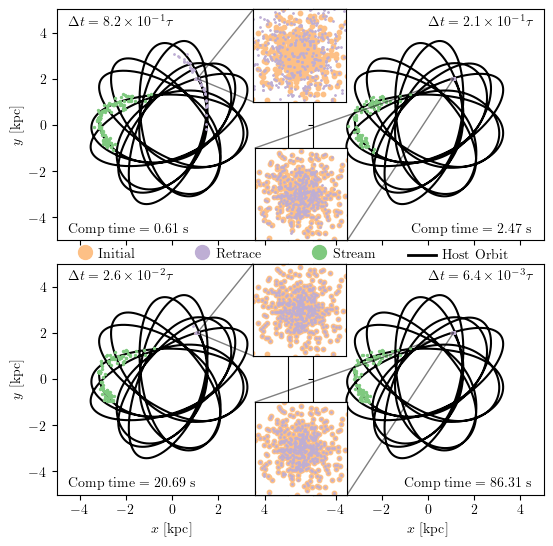

In [9]:
fig = plt.figure(figsize=(8.3-2, 8.3-2))
gs = fig.add_gridspec(2, 2, hspace=0.1, wspace=0.1)
axes = [ ]
for i in range(4):
    axes.append(fig.add_subplot(gs[i // 2, i % 2]))

textcoordleft = [0.05, 0.95]
textcoordright = [0.95, 0.95]
paramsright = {'ha': 'right', 'va': 'center', 'fontsize': "medium"}
paramsleft = {'ha': 'left', 'va': 'center', 'fontsize': "medium"}
for i in range(len(fnames)):
    axes[i].plot(hostorbit[i][0,6:], hostorbit[i][1,6:], 'k-', label=r'$\mathrm{Host~orbit}$',zorder=0)
    scatStream=axes[i].scatter(streamfinal[i][0,:], streamfinal[i][1,:], s=2,   label=r'$\mathrm{Stream}$')
    scatRetrace=axes[i].scatter(stream_retrace[i][0,:], stream_retrace[i][1,:], s=1, label=r'$\mathrm{Stream~retrace}$', zorder=10)
    scatInit=axes[i].scatter(streaminitial[i][0,:], streaminitial[i][1,:], s=1, label=r'$\mathrm{Stream~initial}$', zorder=1)
    axes[i].set_xlim(-5,5)
    axes[i].set_ylim(-5,5)
    axes[i].set_aspect('equal')
    if np.mod(i, 2) == 0:
        print(i)
        axes[i].text(textcoordleft[0], textcoordleft[1], integration_summary[i]['alpha_formatted_boost'], transform= axes[i].transAxes, **paramsleft)
        axes[i].text(textcoordleft[0], 0.05, integration_summary[i]['text_comp_time'], transform=axes[i].transAxes, **paramsleft)
    if np.mod(i, 2) == 1:
        print(i)
        axes[i].text(textcoordright[0], textcoordright[1], integration_summary[i]['alpha_formatted_boost'],transform= axes[i].transAxes, **paramsright)
        axes[i].text(textcoordright[0], 0.05, integration_summary[i]['text_comp_time'], transform=axes[i].transAxes, **paramsright)


coord1=[0.85, 0.60, 0.4, 0.4]
coord2=[-.25, 0.0, 0.4, 0.4]
inset_coordaintes = [
    coord1,
    coord2,
    coord1,
    coord2,
]

axins = [ ]
for i in range(len(fnames)):
    axins.append(axes[i].inset_axes(inset_coordaintes[i], zorder=10))  # Set a high zorder
    axins[i].scatter(streaminitial[i][0],   streaminitial[i][1], s=10, c=scatInit.get_edgecolor())
    axins[i].scatter(stream_retrace[i][0], stream_retrace[i][1], s=1, c=scatRetrace.get_edgecolor())
    axins[i].set_aspect('equal', adjustable='box')
    axes[i].indicate_inset_zoom(axins[i], edgecolor="black", zorder=101)
    radius = 2*hostparams[i][-1]
    axins[i].set_xlim(hostorbit[i][0,0] + - radius, hostorbit[i][0,0]  + radius)
    axins[i].set_ylim(hostorbit[i][1,0] + - radius, hostorbit[i][1,0]  + radius)
    axins[i].set_xticks([])
    axins[i].set_yticks([])

axes[0].set_xticklabels([])
axes[1].set_xticklabels([])
axes[1].set_yticklabels([])
axes[3].set_yticklabels([])
axes[2].set_xlabel(r"$x~[\mathrm{kpc}]$")
axes[3].set_xlabel(r"$x~[\mathrm{kpc}]$")
axes[0].set_ylabel(r"$y~[\mathrm{kpc}]$")
axes[2].set_ylabel(r"$y~[\mathrm{kpc}]$")
# axes[2].set_xticklabels([])
# axes[3].set_xticklabels([])

length = 2 + 0.15 # .15 is assumed gap between axes
# spacing: length = 2c + 3d
c = .12
d = (length - c) / 4

axes[2].scatter(c, 1.05, s=100, c=scatInit.get_edgecolor(),transform=axes[2].transAxes, zorder=100, clip_on=False)
axes[2].text(c+c/2, 1.0375, r"$\mathrm{Initial}$", transform=axes[2].transAxes, zorder=100, clip_on=False, ha='left', va='center')

axes[2].scatter(c + d, 1.05, s=100, c=scatRetrace.get_edgecolor(),transform=axes[2].transAxes, zorder=100, clip_on=False)
axes[2].text(c + d + c/2, 1.0375, r"$\mathrm{Retrace}$", transform=axes[2].transAxes, zorder=100, clip_on=False, ha='left', va='center')

axes[2].scatter(c + 2*d, 1.05, s=100, c=scatStream.get_edgecolor(),transform=axes[2].transAxes, zorder=100, clip_on=False)
axes[2].text(c + 2*d + c/2, 1.0375, r"$\mathrm{Stream}$", transform=axes[2].transAxes, zorder=100, clip_on=False, ha='left', va='center')

axes[2].plot([c + 3*d - c, c + 3*d], [1.0375, 1.0375], 'k-', lw=2, transform=axes[2].transAxes, zorder=100, clip_on=False)
axes[2].text(3*d + 1.2*c, 1.0375, r"$\mathrm{Host~Orbit}$", transform=axes[2].transAxes, zorder=100, clip_on=False, ha='left', va='center')

for i in range(len(fnames)):
    fig.add_axes(axins[i])

fig.savefig(figname, bbox_inches='tight', dpi=300)

make the histogram

In [10]:
NP=energy_errors[0]['errERetrace'].shape[0]
nbins = np.ceil(int(np.sqrt(NP)))
bins = np.logspace(-9,-1.9)

In [11]:
cmap = mpl.colormaps['copper']
norm = mpl.colors.Normalize(vmin=0, vmax=len(fnames)-1)
colors = cmap(norm(np.arange(len(fnames))))
colors= colors[::-1]

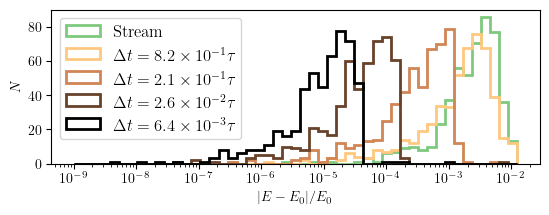

In [12]:
fig = plt.figure(figsize=(8.3-2, 2))
axis= fig.add_subplot(111)
axis.hist(energy_errors[-1]["errEFinal"], bins=bins, histtype='step', 
          color=scatStream.get_facecolor(),linewidth=2, linestyle='-', zorder=0, alpha=1,
            label=r'$\mathrm{Stream}$')
for i in range(len(fnames)):
    axis.hist(energy_errors[i]['errERetrace'], bins=bins, histtype='step',linewidth=2,
              color=colors[i], linestyle='-', zorder=1,
              label=integration_summary[i]['alpha_formatted_boost'])
    
axis.set_xscale('log')
axis.set_xlabel(r'$|E - E_0| / E_0$')
axis.set_ylabel(r'$N$')
axis.legend(fontsize='large')
fig.savefig("../../images/NumericalErrorStreamRetrace_EnergyErrors.png", bbox_inches='tight', dpi=300)